                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            WLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3137.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           4.27e-26
Time:                        14:40:07   Log-Likelihood:                -277.18
No. Observations:                  25   AIC:                             558.4
Df Residuals:                      23   BIC:                             560.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.709e+05   2.01e+04     28.472      0.0

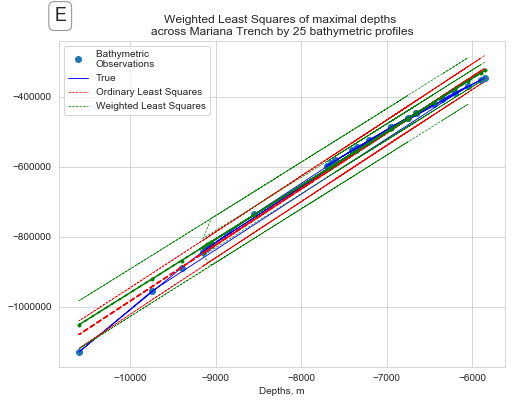

In [9]:
from __future__ import print_function

%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
import seaborn as sns
from patsy import dmatrices
import os
sns.set_style('whitegrid')

# Step-2. Import data
os.chdir('/Users/pauline/Documents/Python')
df = pd.read_csv("Tab-Morph.csv")
df = df.dropna()
nsample = 25
#x = np.linspace(0, 25, nsample)
x = df.Min
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e 
X = X[:,[0,1]]

# Step-3.
mod_wls = sm.WLS(y, X, weights=1./(w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

# Step-4.
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

# Step-5.
se = np.vstack([[res_wls.bse], [res_ols.bse], [res_ols.HC0_se], 
                [res_ols.HC1_se], [res_ols.HC2_se], [res_ols.HC3_se]])
se = np.round(se,4)
colnames = ['x1', 'const']
rownames = ['WLS', 'OLS', 'OLS_HC0', 'OLS_HC1', 'OLS_HC3', 'OLS_HC3']
tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

# Step-6.
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb,X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)

# Step-7.
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

# Step-8.
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="Bathymetric \nObservations", linewidth=.7)
ax.plot(x, y_true, 'b-', label="True", linewidth=.9)
# OLS
ax.plot(x, res_ols.fittedvalues, 'r--')
ax.plot(x, iv_u_ols, 'r--', label="Ordinary Least Squares", linewidth=.7)
ax.plot(x, iv_l_ols, 'r--', linewidth=.7)
# WLS
ax.plot(x, res_wls.fittedvalues, 'g--.')
ax.plot(x, iv_u, 'g--', label="Weighted Least Squares", linewidth=.7)
ax.plot(x, iv_l, 'g--', linewidth=.7)
ax.legend(loc="best");
ax.set_xlabel('Depths, m', fontsize=10)

plt.title("Weighted Least Squares of maximal depths \nacross Mariana Trench by 25 bathymetric profiles", 
          fontsize=12)
plt.annotate('E', xy=(-0.01, 1.06), xycoords="axes fraction", fontsize=18,
           bbox=dict(boxstyle='round, pad=0.3', fc='w', edgecolor='grey', linewidth=1, alpha=0.9))
plt.show()